In [39]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import csv

In [40]:
df = pd.read_csv("experiment_dataset.csv", parse_dates=["date"])

In [41]:
df.head()
df.info()
df["is_test"].value_counts() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   campaign_name             60 non-null     object        
 1   date                      60 non-null     datetime64[ns]
 2   is_test                   60 non-null     int64         
 3   spend_usd                 60 non-null     int64         
 4   impressions               59 non-null     float64       
 5   reach                     59 non-null     float64       
 6   website_clicks            59 non-null     float64       
 7   searches                  59 non-null     float64       
 8   view_content              59 non-null     float64       
 9   add_to_cart               59 non-null     float64       
 10  purchase                  59 non-null     float64       
 11  ctr                       59 non-null     float64       
 12  view_content_rate       

is_test
0    30
1    30
Name: count, dtype: int64

In [42]:
control = df[df["is_test"] == 0]
test = df[df["is_test"] == 1]

In [43]:
# print("Control columns:", control.columns.tolist()) 
# print("Test columns:", test.columns.tolist()) #used to solve keyerror issue in metrics 

In [44]:
metrics = [
    "ctr",
    "purchase_rate_click",
    "purchase_rate_impression",
    "cost_per_purchase "
] #assign metrics to a list

In [45]:
summary = [] #assign statistical summary of metrics to a list

for m in metrics:
    summary.append({
        "metric": m,
        "control_mean": control[m].mean(),
        "test_mean": test[m].mean(),
        "control_median": control[m].median(),
        "test_median": test[m].median(),
        "control_std": control[m].std(ddof=1),
        "test_std": test[m].std(ddof=1),
        "control_n": control[m].notna().sum(),
        "test_n": test[m].notna().sum(),
        "control_skew": stats.skew(control[m].dropna()) if control[m].notna().sum() > 2 else np.nan,
        "test_skew": stats.skew(test[m].dropna()) if test[m].notna().sum() > 2 else np.nan
    })
    
    
eda_df = pd.DataFrame(summary).round(4)
eda_df #display summary of metrics in a table

,metric,control_mean,test_mean,control_median,test_median,control_std,test_std,control_n,test_n,control_skew,test_skew
0,ctr,0.0510,0.1024,0.0472,0.0804,0.0205,0.0677,29,30,0.2138,1.6211
1,purchase_rate_click,0.1148,0.0923,0.1023,0.0845,0.0684,0.0445,29,30,1.2381,0.9170
2,purchase_rate_impression,0.0050,0.0084,0.0047,0.0068,0.0022,0.0052,29,30,0.7022,1.1464
3,cost_per_purchase,5.0523,5.8996,4.6210,5.0628,2.1170,2.8008,29,30,0.7318,0.8557


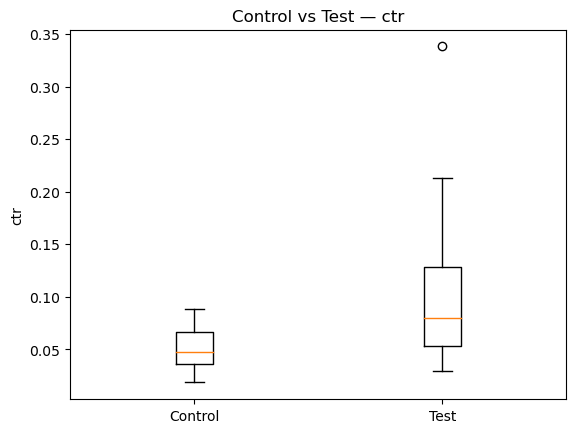

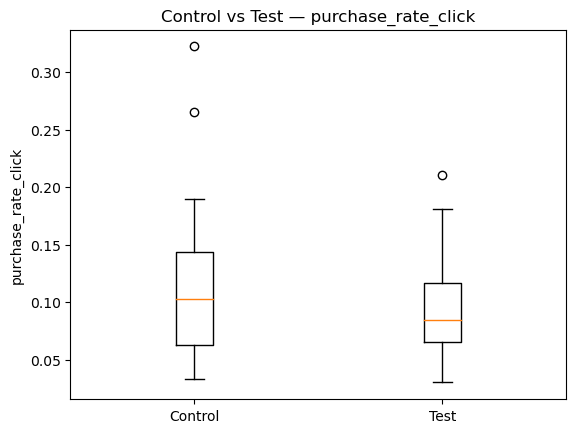

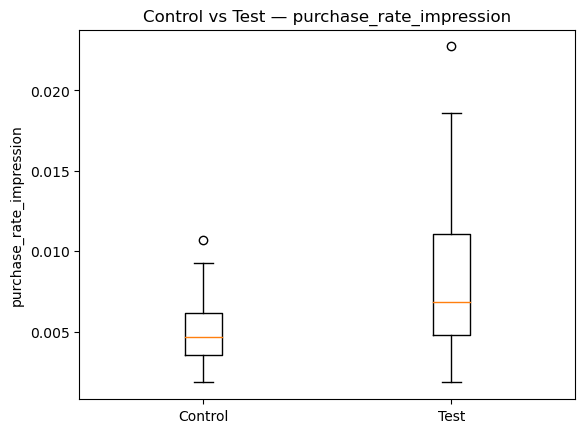

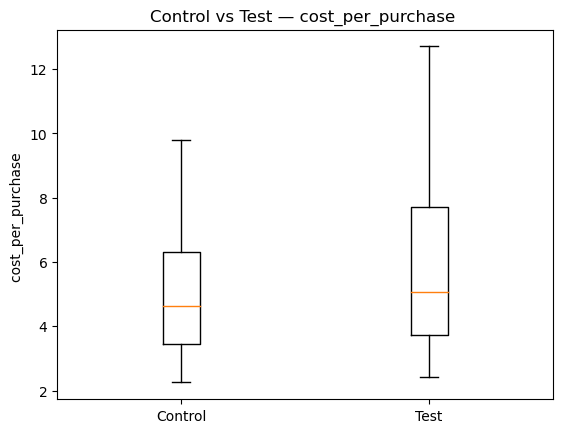

In [46]:
for m in metrics: #for every metric this will generate one boxplot comparing control vs test
    plt.figure()
    plt.boxplot(
        [control[m].dropna(), test[m].dropna()], #drop missing values and use the boxplot to pass through a list of two arrays
        labels=["Control", "Test"]
    )
    plt.title(f"Control vs Test — {m}")
    plt.ylabel(m)
    plt.show()

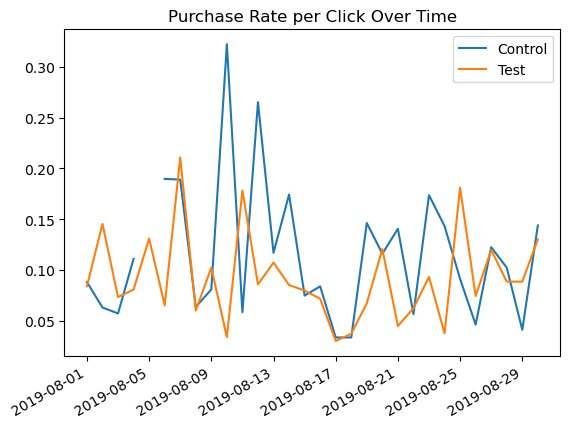

In [53]:
plt.figure()
plt.plot(
    control.groupby("date")["purchase_rate_click"].mean(), #computes the average purchase rate per click for each date for control

    label="Control"
)
plt.plot(
    test.groupby("date")["purchase_rate_click"].mean(), #computes the average purchase rate per click for each date for test
    label="Test"
)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) #use current axes and choose tick positions with applicable date intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) #controls how a tick is displayed and formats the date
plt.gcf().autofmt_xdate() #rotates and spaces the date labels so they don’t overlap

plt.legend()
plt.title("Purchase Rate per Click Over Time")
plt.show()

In [48]:
# Null (H₀): μ_test = μ_control
# Alternative (H₁): μ_test ≠ μ_control

In [ ]:
#Cohens_d is used to measure how big or practically significant the difference is between the control/group values

In [49]:
def cohens_d(control_vals, test_vals): #this function takes two series of values from control and test group
    c = control_vals.dropna() #handles null values
    t = test_vals.dropna()
    
    n_c, n_t = len(c), len(t) #use len() to find the sample size for control and test groups
    if n_c < 2 or n_t < 2: #anything less than two data points will not compute the variance
        return np.nan #this will also return "nan" for effect size as undefined
    
    pooled_std = np.sqrt(
        ((n_c - 1) * c.var(ddof=1) + (n_t - 1) * t.var(ddof=1)) / (n_c + n_t - 2)
    ) #calculate the pooled standard deviation
    
    return (t.mean() - c.mean()) / pooled_std #measure the standardized difference in means of control and test group

In [ ]:
# Bootstrap_cirepeatedly resamples both groups (with replacement), computes the mean difference each time, and uses the distribution of those differences to estimate a 95% confidence interval

In [50]:
def bootstrap_ci(control_vals, test_vals, n_boot=2000, seed=42): #this function takes two series of values from control and test group, the bootstrap sample size, and the seed for reproducing differences between control and group
    rng = np.random.default_rng(seed) #use NumPy for a random number generator for seed
    
    c = control_vals.dropna().values #handles null values
    t = test_vals.dropna().values
    
    diffs = [] #initialize an empty list to store bootstrap mean differences
    for _ in range(n_boot): #runs the bootstrap loop about 2000 times and creates a synthetic experiment each time
        diffs.append(
            rng.choice(t, len(t), replace=True).mean() #draws a sample from the bootstrap experiment and computes the mean for test then subtract from control mean and store in diffs
            rng.choice(c, len(c), replace=True).mean() #draws a sample from the bootstrap experiment and computes the mean for control then subtract from test mean and store in diffs
        ) #then subtract test mean and control mean and store in diffs
        
    return np.percentile(diffs, [2.5, 97.5]) #measure the 2.5th and 97.5th percentiles to find the 95% confidence interval for mean differences

In [55]:
results = [] #initialize empty list

for m in metrics: #loop through metrics for control and test values
    c_vals = control[m]
    t_vals = test[m]
    
    t_stat, t_p = stats.ttest_ind(
        t_vals.dropna(),
        c_vals.dropna(),
        equal_var=False
    ) #perform a Welch’s t‑test to compare the mean of test and control groups

    
    u_stat, u_p = stats.mannwhitneyu(
        t_vals.dropna(),
        c_vals.dropna(),
        alternative="two-sided"
    ) #perform a Mann–Whitney U test for skewed data as an alternative for the t-test, this creates robustness
    
    abs_lift = t_vals.mean() - c_vals.mean() #measure absolute lift by subtracting mean of test from control to see how much of a difference exists between the two
    pct_lift = abs_lift / c_vals.mean() if c_vals.mean() != 0 else np.nan #measure percent lift relative to control
    
    d = cohens_d(c_vals, t_vals) #measure the standardized effect size
    ci_low, ci_high = bootstrap_ci(c_vals, t_vals) #compute the 95% confidence interval using bootstrap sample
    
    results.append({
        "metric": m,
        "control_mean": c_vals.mean(),
        "test_mean": t_vals.mean(),
        "absolute_lift": abs_lift,
        "percent_lift": pct_lift,
        "t_pvalue": t_p,
        "mw_pvalue": u_p,
        "cohens_d": d,
        "ci_lower": ci_low,
        "ci_upper": ci_high
    })

results_df = pd.DataFrame(results).round(4)
results_df #display the results in a table

,metric,control_mean,test_mean,absolute_lift,percent_lift,t_pvalue,mw_pvalue,cohens_d,ci_lower,ci_upper
0,ctr,0.0510,0.1024,0.0515,1.0099,0.0003,0.0003,1.0213,0.0282,0.0780
1,purchase_rate_click,0.1148,0.0923,-0.0225,-0.1957,0.1428,0.3061,-0.3907,-0.0509,0.0053
2,purchase_rate_impression,0.0050,0.0084,0.0034,0.6848,0.0020,0.0041,0.8521,0.0016,0.0055
3,cost_per_purchase,5.0523,5.8996,0.8473,0.1677,0.1946,0.2717,0.3405,-0.4080,2.0293
